### Objective of the notebook:

In this notebook, we will analyze results of the final model.

- Create confusion matrix
- Create feature importance chart
- Visualize model predictions in order-recency bins matrix
- Analyze model performance in order-recency bins matrix
- Save client_id, y_pred, y_actual results

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import lightgbm 

from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore") 

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
break_point = datetime(2017, 2, 28)

/Users/kaan.simsek/anaconda3/envs/forecasting/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Importing datasets

In [2]:
def read_data():
    
    print('Reading files...')    
    order_df = pd.read_csv('../input/machine_learning_challenge_order_data.csv')
    print('Order data has {} rows and {} columns'.format(order_df.shape[0], order_df.shape[1]))
    label_df = pd.read_csv('../input/machine_learning_challenge_labeled_data.csv')
    print('Label data has {} rows and {} columns'.format(label_df.shape[0], label_df.shape[1]))
    df = order_df.merge(label_df, on='customer_id')
    print('The final data has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    print("")
    return df

### Change data types and reduce memory usage

In [3]:
def reduce_mem_usage(df, verbose=False):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    print("")
    return df

### Label encode categorical features

In [4]:
def transform_data(df):

    labelencoder = LabelEncoder()

    for i in ['restaurant_id', 'city_id', 'payment_id', 'platform_id', 'transmission_id']:
        df[i] = labelencoder.fit_transform(df[i])

    return df

### Convert raw data to a session format

In [5]:
def getWeeklyDates(df, break_point):

    df['order_date'] = pd.to_datetime(df['order_date'])
    three_day = df[df['order_date'] >= break_point - timedelta(days=3)]
    one_week = df[df['order_date'] >= break_point - timedelta(days=7)]
    two_week = df[df['order_date'] >= break_point - timedelta(days=14)]
    four_week = df[df['order_date'] >= break_point - timedelta(days=28)]
    twelve_week = df[df['order_date'] >= break_point - timedelta(days=84)]
    twenty_four_week = df[df['order_date'] >= break_point - timedelta(days=168)]
    all_week = df
    return three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week

In [6]:
def feature_engineering(df, break_point):
    
    df['customer_order_rank'] = df['customer_order_rank'].fillna(method='ffill')

    df['order_date'] = pd.to_datetime(df['order_date']) 
    df['recency'] = (break_point - df['order_date']) / np.timedelta64(1, 'D')
    df['first_order_date'] = df.groupby(['customer_id'])['order_date'].transform('first')
    df['age_of_user'] = (break_point - df['first_order_date']) / np.timedelta64(1, 'D')

    df['year'] = df['order_date'].dt.year
    df['month'] = df['order_date'].dt.month
    df['week'] = df['order_date'].dt.week
    df['day'] = df['order_date'].dt.day
    df['dayofweek'] = df['order_date'].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    
    df['demand'] = 1
    
    df['order_date_shift'] = df.groupby('customer_id')['order_date'].shift()
    df['date_diff'] = (df['order_date'] - df['order_date_shift']) / np.timedelta64(1, 'D')

    three_day, one_week, two_week, four_week, twelve_week, twenty_four_week,all_week = getWeeklyDates(df, break_point)

    col = ['demand', 'is_failed','voucher_amount','delivery_fee', 'amount_paid', 'date_diff']
    three_day = three_day.groupby('customer_id')[col].sum().add_prefix('three_day_').reset_index()
    one_week = one_week.groupby('customer_id')[col].sum().add_prefix('one_week_').reset_index()
    two_week = two_week.groupby('customer_id')[col].sum().add_prefix('two_week_').reset_index()
    four_week = four_week.groupby('customer_id')[col].sum().add_prefix('four_week_').reset_index()
    twelve_week = twelve_week.groupby('customer_id')[col].sum().add_prefix('twelve_week_').reset_index()
    twenty_four_week = twenty_four_week.groupby('customer_id')[col].sum().add_prefix('twenty_four_week_').reset_index()
    all_week = all_week.groupby('customer_id')[col].sum().add_prefix('all_week_').reset_index()
    
    df = df.groupby('customer_id').last().reset_index()
    df = df.merge(three_day, how='left').merge(one_week, how='left').merge(two_week, how='left').merge(four_week,
    'left').merge(twelve_week,'left').merge(twenty_four_week,'left').merge(all_week,'left').reset_index()

    df['city_count'] = df.groupby('city_id')['customer_id'].transform('nunique')
    df['rest_count'] = df.groupby('restaurant_id')['customer_id'].transform('nunique')
    
    df['city_mean'] = df.groupby('city_id')['is_returning_customer'].transform('mean')
    df['rest_mean'] = df.groupby('restaurant_id')['is_returning_customer'].transform('mean')

    return df

### Run the lgb model and calculate scores


In [7]:
def run_lgb(df):
    
    y = df['is_returning_customer']
    X = df.drop(columns=['index', 'customer_id', 'order_date', 'is_returning_customer',
                        'first_order_date', 'order_date_shift'])    
    
    clf = lightgbm.LGBMClassifier(num_leaves= 10, n_estimators= 700, min_child_weight= 5, max_depth= 9, 
                                  learning_rate= 0.05, colsample_bytree= 0.9000000000000001)
    
    clf.fit(X, y)
    
    auc_mean = cross_val_score(clf, X, y, cv = kfold, scoring = "roc_auc").mean()
    auc_std = cross_val_score(clf, X, y, cv = kfold, scoring = "roc_auc").std()

    acc_mean = cross_val_score(clf, X, y, cv = kfold, scoring = "accuracy").mean()
    acc_std = cross_val_score(clf, X, y, cv = kfold, scoring = "accuracy").std()
    
    model_result = round(pd.DataFrame({'Roc-Auc Mean':auc_mean,'Roc-Auc Std':auc_std,
                                'Accuracy Mean':acc_mean, 'Accuracy Std':acc_std}, 
                                 index=['LGBM']), 4) 
    
    print(model_result)

    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(9,12))

    sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='2.0f', ax=ax0).set_title('Confusion matrix')

    pd.Series(clf.feature_importances_,X.columns).sort_values()[-20:].plot.barh(width=0.8,
                                            color='navy', ax=ax1).set_title('Feature Importance')
    
                                                                                
    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    model_output = pd.DataFrame(y_pred, index=df.customer_id, columns=['y_pred']).reset_index()
    model_output['y_actual'] = y
    model_output = model_output.merge(df[['customer_id', 'customer_order_rank', 'recency']], on='customer_id')
    return model_output

Reading files...
Order data has 786600 rows and 13 columns
Label data has 245455 rows and 2 columns
The final data has 786600 rows and 14 columns

Mem. usage decreased to 42.76 Mb (52.5% reduction)

      Roc-Auc Mean  Roc-Auc Std  Accuracy Mean  Accuracy Std
LGBM        0.8447       0.0013         0.8461        0.0005


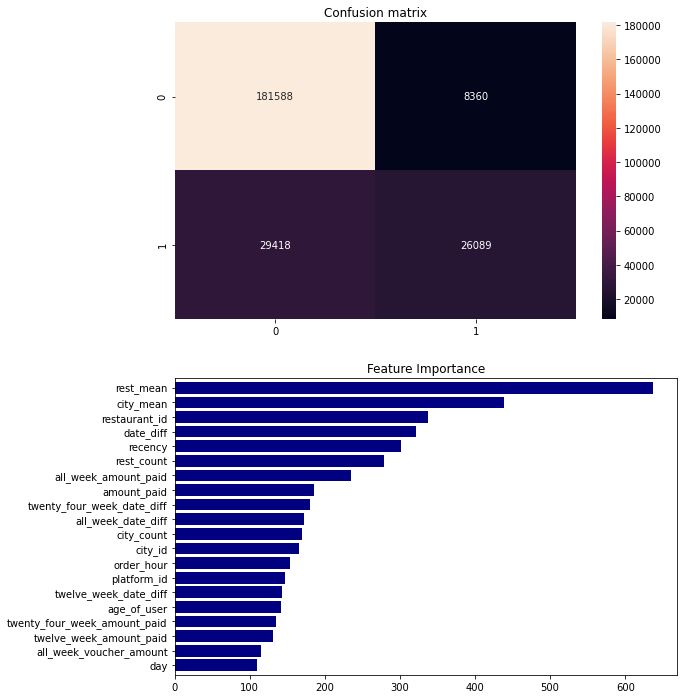

In [8]:
def execute_pipeline():
    
    df = read_data()
    df = reduce_mem_usage(df, True)
    df = transform_data(df)
    df = feature_engineering(df, break_point)
    predicted = run_lgb(df)
    return predicted

model_output = execute_pipeline()

### Model interpretation 

In [10]:
order_bins = [0, 1, 4, 9, 49, 99, 999]
order_labels = ["1", "2-4", "5-9", "10-49", "50-99", "100+"]
model_output['order_binned'] = pd.cut(model_output['customer_order_rank'], bins=order_bins, labels=order_labels)

recency_bins = [0, 7, 14, 28, 84, 168, 1680]
recency_labels = ["0-7", "8-14", "15-28", "29-84", "85-168", "168+"]
model_output['recency_binned'] = pd.cut(model_output['recency'], bins=recency_bins, labels=recency_labels)

model_output['is_true'] = np.where(model_output.y_pred==model_output.y_actual, 1, 0)

y_actual = model_output.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='y_actual', aggfunc='mean')
y_pred = model_output.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='y_pred', aggfunc='mean')
customer_count = model_output.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='y_pred', aggfunc='count')
model_performance = model_output.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='is_true', aggfunc='mean')

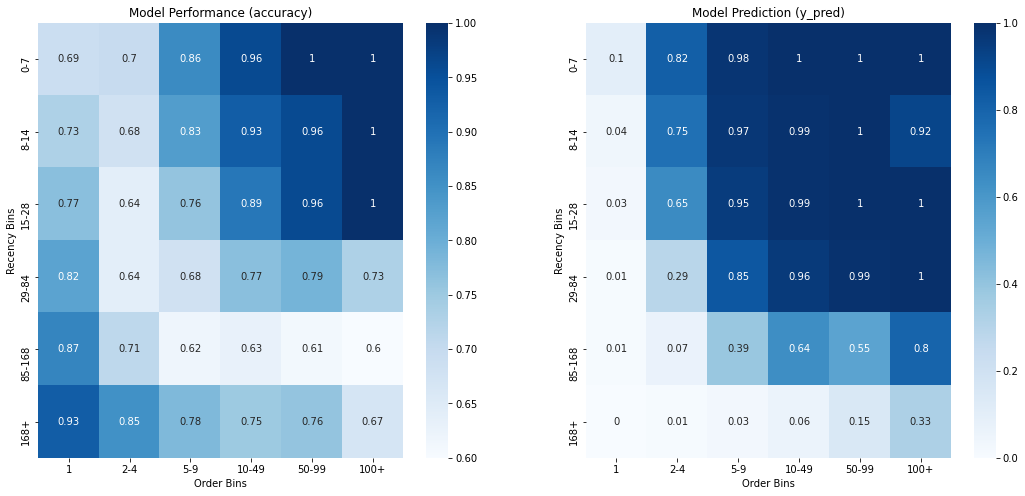

In [11]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(18, 8))

sns.heatmap(data = round(model_performance, 2), annot = True, cmap='Blues', fmt='g', ax=ax0)
ax0.set_title('Model Performance (accuracy)')
ax0.set_xlabel('Order Bins')
ax0.set_ylabel('Recency Bins')

sns.heatmap(data = round(y_pred, 2), annot = True, cmap='Blues', fmt='g', ax=ax1)
ax1.set_title('Model Prediction (y_pred)')
ax1.set_xlabel('Order Bins')
ax1.set_ylabel('Recency Bins')
plt.show()

### What is next?

LightGBM model labels almost all newcomers and 168+ recency customers as churn. (right below)

Model performance (y_pred=y_actual) is higher for 10+ customers but lower for 2-4 order and 12-24 week recency customer cohorts. (left below)

For further analysis, the features below would increase model performance: 

- Rating
- Comment
- Delivery time
- Live chat experience
- Cancel reasons (courier, rest, user, etc.)
- Age, gender, device type, district, OS type

It would be good to get geolocation data because it helps to understand whether a customer in our service area currently. (holiday, business trip, etc.)

We could spend more time on different models (NN, CatBoost, stacked models, etc.) or tuning hyperparameters, but there is a trade-off between the time you spent and improvement in the model scores. 

Now, we will create a production-ready py version of the final model.